# Imports

In [1]:
import torch
import re
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import gc

from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from datasets import Dataset
from unsloth import FastLanguageModel
from trl import GRPOTrainer, GRPOConfig
from maze_verifier import MazeVerifier
from base.data import Data
from base.verifier import Verifier
from base.env import Env
from maze_env import MazeEnv
from tqdm.auto import tqdm

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
random.seed(37)

In [3]:
SYSTEM_PROMPT = """
Respond in the following format:
<think>
...
</think>
<answer>
...
</answer>
"""

maze_env = MazeEnv()

# Rewards

## Format

In [4]:
def format_reward_func(completions, **kwargs) -> List[float]:
  """
  Reward for XML format
  """
  pattern = r"<think>.*?</think>\s*<answer>.*?</answer>"
  responses = [completion[0]["content"] for completion in completions]
  return [1.0 if re.search(pattern, r, re.DOTALL) else 0.0 for r in responses]

def extract_answer_from_response(response, **kwargs) -> str:
  matches = list(re.finditer(r"<answer>(.*?)</answer>", response, re.DOTALL))
  if matches:
    return matches[-1].group(1).strip()
  clean_response = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL)
  return clean_response.strip()

## Correctness

In [5]:
def correctness_reward_func(prompts, completions, answer, **kwargs) -> List[float]:
  """
  Reward for correct answer
  Compare test answer with gold answer
  """

  responses = [completion[0]["content"] for completion in completions]
  rewards = []
  
  for response_text, data_json in zip(responses, answer):
    data = Data.from_json_str(data_json)
    response_answer = extract_answer_from_response(response_text)
    is_correct = maze_env.verify(data, response_answer)
    rewards.append(5.0 if is_correct else 0.0)
  
  return rewards

# Datasets

## Convertions to GRPO Dataset

In [6]:
def create_grpo_dataset(data_list: List[Data]) -> Dataset:
  """
  Converting List[Data] to Dataset for GRPOTrainer
  """
  prompts = []
  answers = []
  for data in data_list:
    full_prompt = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": data.to_json_str()}
    ]
    prompts.append(full_prompt)
    answers.append(data.to_json_str())

  return Dataset.from_dict({
  "prompt": prompts,
  "answer": answers
  })
  
def generate_grpo_dataset(env: Env, difficulty, num_samples, attempts=5) -> Dataset:
  result = env.generate(num_samples, attempts, difficulty)
  return create_grpo_dataset(result)

## Train

In [7]:
train_generator_params = [(1, 100), (2, 150), (3, 200)] # (difficulty, num_samples)

train_dataset = []
for difficulty, num_samples in train_generator_params:
  train_dataset.extend(generate_grpo_dataset(maze_env, difficulty, num_samples))

## Test

In [8]:
test_generator_params = [('Easy', 1, 50), ('Medium', 2, 75), ('Hard', 3, 100)] # (level, difficulty, num_samples)

test_dataset = dict()
for level, difficulty, num_samples in test_generator_params:
  test_dataset[level] = generate_grpo_dataset(maze_env, difficulty, num_samples)

# Models

In [9]:
max_seq_length = 4096
lora_rank = 16

In [10]:
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = "unsloth/Qwen2.5-1.5B-Instruct", # unsloth
  max_seq_length = max_seq_length,
  max_lora_rank = lora_rank,
  gpu_memory_utilization = 0.9
)

==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [11]:
model = FastLanguageModel.get_peft_model(
  model,
  r = lora_rank,
  target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", 
                    "gate_proj", "up_proj", "down_proj",],
  lora_alpha = lora_rank,
  use_gradient_checkpointing = False, 
  random_state = 3407
)

Unsloth 2025.11.6 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


## GRPO config

In [12]:
training_args = GRPOConfig(
  output_dir = "outputs/qwen-maze-grpo",
  learning_rate = 1.5e-5,
  adam_beta1 = 0.9,
  adam_beta2 = 0.99,
  weight_decay = 0.1,
  warmup_ratio = 0.1,
  lr_scheduler_type = "cosine",
  logging_steps = 10,
  bf16 = True,
  per_device_train_batch_size = 1,
  gradient_accumulation_steps = 16,
  num_generations = 16, 
  max_prompt_length = 2048,
  max_completion_length = 512,
  num_train_epochs = 1, 
  save_steps = 100,
  max_grad_norm = 0.1,
  temperature = 0.9,
  report_to = "none",
  gradient_checkpointing = False,
)

# Evaluate

In [13]:
def log_answer(data, response):
  grid = data.metadata['grid']
  grid_view = ""
  for rows in grid:
    grid_view += "".join(map(str, rows)) + "\n"
  print("Grid:\n", grid_view)
  print("Response:\n", response)

In [14]:
def get_batch_responses(model, tokenizer, batch_prompts):
  messages = [tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True) for prompt in batch_prompts]

  inputs = tokenizer(messages, return_tensors="pt", padding=True, padding_side="left").to("cuda")

  outputs = model.fast_generate(
    **inputs,
    max_new_tokens=512,
    temperature=0.2,
    use_cache=True,
    pad_token_id=tokenizer.eos_token_id
  )
  
  input_len = inputs.input_ids.shape[1]
  generated = outputs[:, input_len:]

  batch_responses = tokenizer.batch_decode(generated, skip_special_tokens=True)
  
  return batch_responses

In [15]:
def evaluate(model, tokenizer, datasets: Dict[str, Dataset], batch_size=8) -> Dict[str, float]:
  results = {}
  
  print("\n--- Evaluation ---")
  
  for name, dataset in datasets.items():
    correct = 0
    prompts = dataset['prompt']
    datas = [Data.from_json_str(data_str) for data_str in dataset['answer']]
    total = len(prompts)
    print(f"Processing {name} ({total})...")
    
    for i in tqdm(range(0, total, batch_size), desc=f"Evaluating {name}"):
      batch_datas = datas[i:i + batch_size]
      batch_prompts = prompts[i:i + batch_size]
      batch_responses = get_batch_responses(model, tokenizer, batch_prompts)
      
      for data, response in zip(batch_datas, batch_responses):
        # log_answer(data, response)
        test_answer = extract_answer_from_response(response)
        if maze_env.verify(data, test_answer):
          correct += 1
      
      print("Correct: ", correct)
    
    acc = correct / total
    results[name] = acc
    print(f"  -> {name} Accuracy: {acc:.2%}")
    
  return results

# Training

In [16]:
trainer = GRPOTrainer(
  model = model,
  processing_class = tokenizer,
  reward_funcs = [format_reward_func, correctness_reward_func],
  args = training_args,
  train_dataset = train_dataset,
)

In [17]:
torch.cuda.empty_cache()
gc.collect()

print("\n=== Training ===")
FastLanguageModel.for_training(model) 

trainer.train(resume_from_checkpoint="outputs/qwen-maze-grpo/checkpoint-200")

trainer.save_model("./grpo_model_final")

print("Done!")

The model is already on multiple devices. Skipping the move to device specified in `args`.



=== Training ===


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 450 | Num Epochs = 1 | Total steps = 450
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correctness_reward_func / mean,rewards / correctness_reward_func / std
210,0.000100,5.962500,0.150000,68.206250,55.600000,142.100000,0.006250,65.535834,55.600000,101.100000,0,0,0,0,0,0.055525,0.993750,0.025000,4.968750,0.125000
220,0.000100,5.906250,0.295783,55.412500,40.900000,128.500000,0.006250,52.650417,40.900000,85.600000,No Log,No Log,No Log,No Log,No Log,0.086898,1.000000,0.000000,4.906250,0.295783
230,0.000100,5.781250,0.375000,52.681250,45.100000,71.900000,0.000000,52.681250,45.100000,71.900000,No Log,No Log,No Log,No Log,No Log,0.068185,1.000000,0.000000,4.781250,0.375000
240,0.000100,5.937500,0.170783,59.712500,51.300000,81.800000,0.000000,59.712500,51.300000,81.800000,No Log,No Log,No Log,No Log,No Log,0.074092,1.000000,0.000000,4.937500,0.170783
250,0.000100,5.925000,0.284157,61.475000,50.400000,125.800000,0.006250,58.845000,50.400000,85.000000,No Log,No Log,No Log,No Log,No Log,0.069784,0.987500,0.034157,4.937500,0.250000
260,0.000100,5.968750,0.125000,53.081250,45.700000,63.700000,0.000000,53.081250,45.700000,63.700000,No Log,No Log,No Log,No Log,No Log,0.072362,1.000000,0.000000,4.968750,0.125000
270,0.000100,5.906250,0.295783,49.350000,42.900000,67.500000,0.000000,49.350000,42.900000,67.500000,No Log,No Log,No Log,No Log,No Log,0.077941,1.000000,0.000000,4.906250,0.295783
280,0.000100,5.931250,0.275000,52.081250,42.200000,109.700000,0.006250,49.268750,42.200000,66.000000,No Log,No Log,No Log,No Log,No Log,0.125398,0.993750,0.025000,4.937500,0.250000
290,0.000300,6.000000,0.000000,54.725000,49.100000,70.400000,0.000000,54.725000,49.100000,70.400000,No Log,No Log,No Log,No Log,No Log,0.251015,1.000000,0.000000,5.000000,0.000000
300,0.000100,6.000000,0.000000,52.612500,46.000000,74.900000,0.000000,52.612500,46.000000,74.900000,No Log,No Log,No Log,No Log,No Log,0.100427,1.000000,0.000000,5.000000,0.000000


Done!


In [17]:
trained_model_path = "grpo_model_final"

trained_model, trained_tokenizer = FastLanguageModel.from_pretrained(
  model_name = trained_model_path,
  max_seq_length = max_seq_length,
  max_lora_rank = lora_rank,
  gpu_memory_utilization = 0.9
)

FastLanguageModel.for_inference(trained_model)

print("\n=== Final Eval ===")
trained_stats = evaluate(trained_model, trained_tokenizer, test_dataset, batch_size=8)

print(trained_stats)

==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

=== Final Eval ===

--- Evaluation ---
Processing Easy (50)...


Evaluating Easy:   0%|          | 0/7 [00:00<?, ?it/s]

Correct:  8
Correct:  16
Correct:  24
Correct:  32
Correct:  40
Correct:  48
Correct:  50
  -> Easy Accuracy: 100.00%
Processing Medium (75)...


Evaluating Medium:   0%|          | 0/10 [00:00<?, ?it/s]

Correct:  8
Correct:  15
Correct:  22
Correct:  30
Correct:  38
Correct:  46
Correct:  53
Correct:  60
Correct:  67
Correct:  69
  -> Medium Accuracy: 92.00%
Processing Hard (100)...


Evaluating Hard:   0%|          | 0/13 [00:00<?, ?it/s]

Correct:  8
Correct:  16
Correct:  24
Correct:  32
Correct:  38
Correct:  43
Correct:  51
Correct:  58
Correct:  65
Correct:  71
Correct:  78
Correct:  86
Correct:  90
  -> Hard Accuracy: 90.00%
{'Easy': 1.0, 'Medium': 0.92, 'Hard': 0.9}


In [18]:
FastLanguageModel.for_inference(model)

print("\n=== Baseline Eval ===")
with model.disable_adapter():
  base_stats = evaluate(model, tokenizer, test_dataset, batch_size=8)

print(base_stats)


=== Baseline Eval ===

--- Evaluation ---
Processing Easy (50)...


Evaluating Easy:   0%|          | 0/7 [00:00<?, ?it/s]

Correct:  3
Correct:  7
Correct:  9
Correct:  12
Correct:  16
Correct:  19
Correct:  20
  -> Easy Accuracy: 40.00%
Processing Medium (75)...


Evaluating Medium:   0%|          | 0/10 [00:00<?, ?it/s]

Correct:  0
Correct:  1
Correct:  3
Correct:  7
Correct:  7
Correct:  7
Correct:  12
Correct:  12
Correct:  13
Correct:  14
  -> Medium Accuracy: 18.67%
Processing Hard (100)...


Evaluating Hard:   0%|          | 0/13 [00:00<?, ?it/s]

Correct:  2
Correct:  5
Correct:  7
Correct:  7
Correct:  9
Correct:  10
Correct:  10
Correct:  14
Correct:  14
Correct:  15
Correct:  18
Correct:  20
Correct:  22
  -> Hard Accuracy: 22.00%
{'Easy': 0.4, 'Medium': 0.18666666666666668, 'Hard': 0.22}


# Graphic

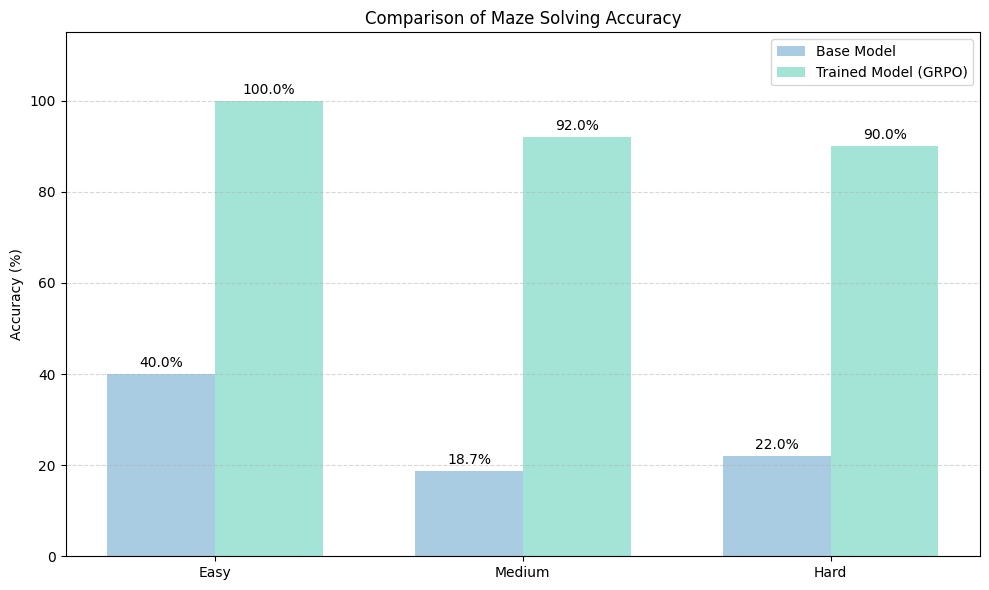

In [25]:
def plot_benchmark(base_stats, trained_stats):
  categories = ['Easy', 'Medium', 'Hard']
  base_means = [base_stats[cat] * 100 for cat in categories]
  trained_means = [trained_stats[cat] * 100 for cat in categories]
  
  x = np.arange(len(categories))
  width = 0.35
  
  fig, ax = plt.subplots(figsize=(10, 6))
  rects1 = ax.bar(x - width/2, base_means, width, label='Base Model', color='#A9CCE3')
  rects2 = ax.bar(x + width/2, trained_means, width, label='Trained Model (GRPO)', color='#A3E4D7')
  
  ax.set_ylabel('Accuracy (%)')
  ax.set_title('Comparison of Maze Solving Accuracy')
  ax.set_xticks(x)
  ax.set_xticklabels(categories)
  ax.legend()
  
  ax.grid(axis='y', linestyle='--', alpha=0.5)
  ax.set_ylim(0, 115)
  
  ax.bar_label(rects1, padding=3, fmt='%.1f%%')
  ax.bar_label(rects2, padding=3, fmt='%.1f%%')
  
  fig.tight_layout()
  plt.show()

plot_benchmark(base_stats, trained_stats)


In [ ]:
username = "TITANOBOXER"
model_name = "Qwen2.5-1.5B-Instruct-maze-solver-grpo"
repo_id = f"{username}/{model_name}"

trained_model.push_to_hub(repo_id, token=True)
trained_tokenizer.push_to_hub(repo_id, token=True)

README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Saved model to https://huggingface.co/TITANOBOXER/Qwen2.5-1.5B-Instruct-maze-solver-grpo


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

In [29]:
from datasets import DatasetDict

dataset_name = "maze-benchmark-test"
dataset_repo_id = f"{username}/{dataset_name}"

final_dataset = DatasetDict(test_dataset)

final_dataset.push_to_hub(dataset_repo_id, token=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/TITANOBOXER/maze-benchmark-test/commit/ec01be6f049a3c69c177a19676a8a0c55cb34d1d', commit_message='Upload dataset', commit_description='', oid='ec01be6f049a3c69c177a19676a8a0c55cb34d1d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/TITANOBOXER/maze-benchmark-test', endpoint='https://huggingface.co', repo_type='dataset', repo_id='TITANOBOXER/maze-benchmark-test'), pr_revision=None, pr_num=None)

In [32]:
from datasets import load_dataset

downloaded_model, downloaded_tokenizer = model, tokenizer = FastLanguageModel.from_pretrained(
  f"{username}/{model_name}",
  max_seq_length = max_seq_length,
  max_lora_rank = lora_rank
)

downloaded_dataset = load_dataset(dataset_repo_id)

print("\n=== Test download Eval ===")
downloaded_stats = evaluate(downloaded_model, downloaded_tokenizer, downloaded_dataset, batch_size=8)

print(downloaded_stats)

==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

=== Test download Eval ===

--- Evaluation ---
Processing Easy (50)...


Evaluating Easy:   0%|          | 0/7 [00:00<?, ?it/s]

Correct:  8
Correct:  16
Correct:  24
Correct:  32
Correct:  40
Correct:  48
Correct:  50
  -> Easy Accuracy: 100.00%
Processing Medium (75)...


Evaluating Medium:   0%|          | 0/10 [00:00<?, ?it/s]

Correct:  8
Correct:  15
Correct:  23
Correct:  31
Correct:  39
Correct:  47
Correct:  54
Correct:  61
Correct:  68
Correct:  71
  -> Medium Accuracy: 94.67%
Processing Hard (100)...


Evaluating Hard:   0%|          | 0/13 [00:00<?, ?it/s]

Correct:  8
Correct:  16
Correct:  24
Correct:  32
Correct:  38
Correct:  42
Correct:  50
Correct:  57
Correct:  64
Correct:  70
Correct:  77
Correct:  85
Correct:  89
  -> Hard Accuracy: 89.00%
{'Easy': 1.0, 'Medium': 0.9466666666666667, 'Hard': 0.89}
